In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# 1) Cargar datos (ajusta el nombre del archivo)
df = pd.read_csv("../data/raw/raw_sales.csv")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datesold      29580 non-null  object
 1   postcode      29580 non-null  int64 
 2   price         29580 non-null  int64 
 3   propertyType  29580 non-null  object
 4   bedrooms      29580 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [9]:
df.describe()

,postcode,price,bedrooms
count,29580.000000,2.958000e+04,29580.000000
mean,2730.249730,6.097363e+05,3.250169
std,146.717292,2.817079e+05,0.951275
min,2600.000000,5.650000e+04,0.000000
25%,2607.000000,4.400000e+05,3.000000
50%,2615.000000,5.500000e+05,3.000000
75%,2905.000000,7.050000e+05,4.000000
max,2914.000000,8.000000e+06,5.000000


In [10]:
# 2) Parseo de fecha (ajusta el nombre de columna si no es 'datesold')
df["datesold"] = pd.to_datetime(df["datesold"], errors="coerce")

In [11]:
# 3) Filtrar a "houses" y 3 bedrooms (ajusta nombres si es distinto)
# Ejemplos típicos: 'propertyType', 'bedrooms', 'price'
df = df[(df["propertyType"].str.lower() == "house") & (df["bedrooms"] == 3)].copy()

In [12]:
# 4) Eliminar los codigos postales que no se van a utilizar
# postcode

df.drop(columns='postcode',axis=0)

,datesold,price,propertyType,bedrooms
1,2007-02-27,290000,house,3
2,2007-03-07,328000,house,3
4,2007-03-21,310000,house,3
6,2007-04-24,399000,house,3
8,2007-05-24,359000,house,3
...,...,...,...,...
24541,2019-07-25,628000,house,3
24542,2019-07-25,731000,house,3
24545,2019-07-25,1130000,house,3
24546,2019-07-26,470000,house,3


In [13]:
# 5) Agregar a frecuencia mensual (~150 obs)
serie = (df
         .set_index("datesold")["price"]
         .resample("MS")          # Month Start
         .mean()
         .asfreq("MS"))

In [14]:
# 6) Limpieza básica
serie = serie.interpolate(limit_direction="both")  # por si hay meses sin ventas

In [15]:
# 7) Verificación despues de la limpieza
print("N observaciones:", len(serie))
print("Rango:", serie.index.min().date(), "->", serie.index.max().date())

N observaciones: 150
Rango: 2007-02-01 -> 2019-07-01


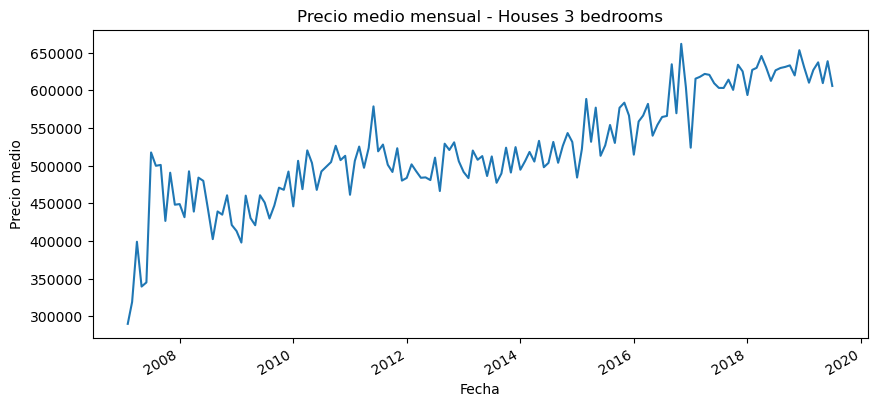

In [16]:
# 8) Representación gráfica (Punto 2 - primera parte)
plt.figure(figsize=(10,4))
plt.plot(serie)
plt.title("Precio medio mensual - Houses 3 bedrooms")
plt.xlabel("Fecha")
plt.ylabel("Precio medio")
plt.xticks(rotation=30, ha="right")
plt.show()

In [17]:
serie

datesold
2007-02-01    290000.000000
2007-03-01    319000.000000
2007-04-01    399000.000000
2007-05-01    339500.000000
2007-06-01    345000.000000
                  ...      
2019-03-01    627037.974684
2019-04-01    637188.392857
2019-05-01    609584.677419
2019-06-01    638709.677419
2019-07-01    605833.152174
Freq: MS, Name: price, Length: 150, dtype: float64

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [19]:
# 9) Descompondremos la serie temporal para conocer su estacionalidad, tendencia y residuos:
# Realizar la descomposición estacional
result = seasonal_decompose(serie, model='multiplicative',period=12)

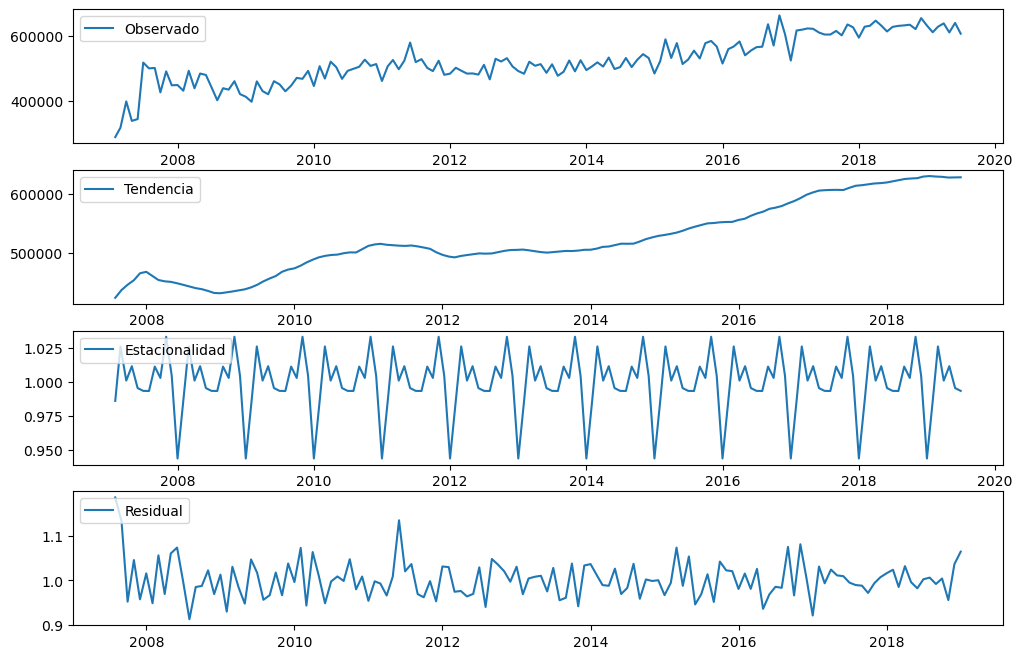

In [20]:
# Visualizar las componentes
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observado')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Tendencia')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
plt.show()

## Desestacionalización

In [21]:
# 1) desestacionalizar la serie temporal
desestacionalizada = serie / result.seasonal
print(desestacionalizada.head())

datesold
2007-02-01    294155.651696
2007-03-01    310962.816960
2007-04-01    398686.652967
2007-05-01    335692.346037
2007-06-01    346634.564750
Freq: MS, dtype: float64


In [22]:
import seaborn as sns

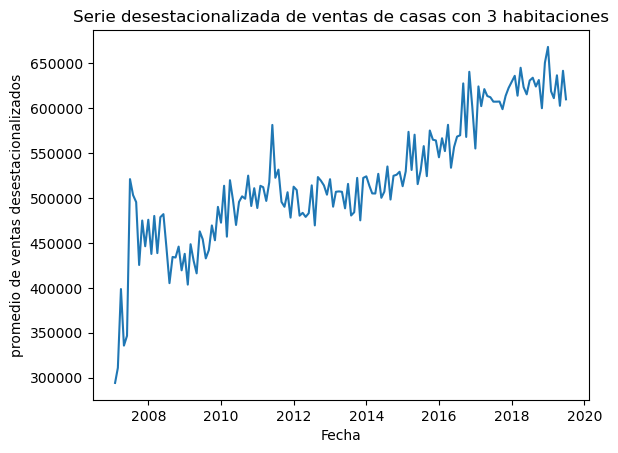

In [23]:
# 2) Gráfico de la desestacionalizada
sns.lineplot(desestacionalizada)
plt.title('Serie desestacionalizada de ventas de casas con 3 habitaciones')
plt.xlabel('Fecha')
plt.ylabel('promedio de ventas desestacionalizados')
plt.show()

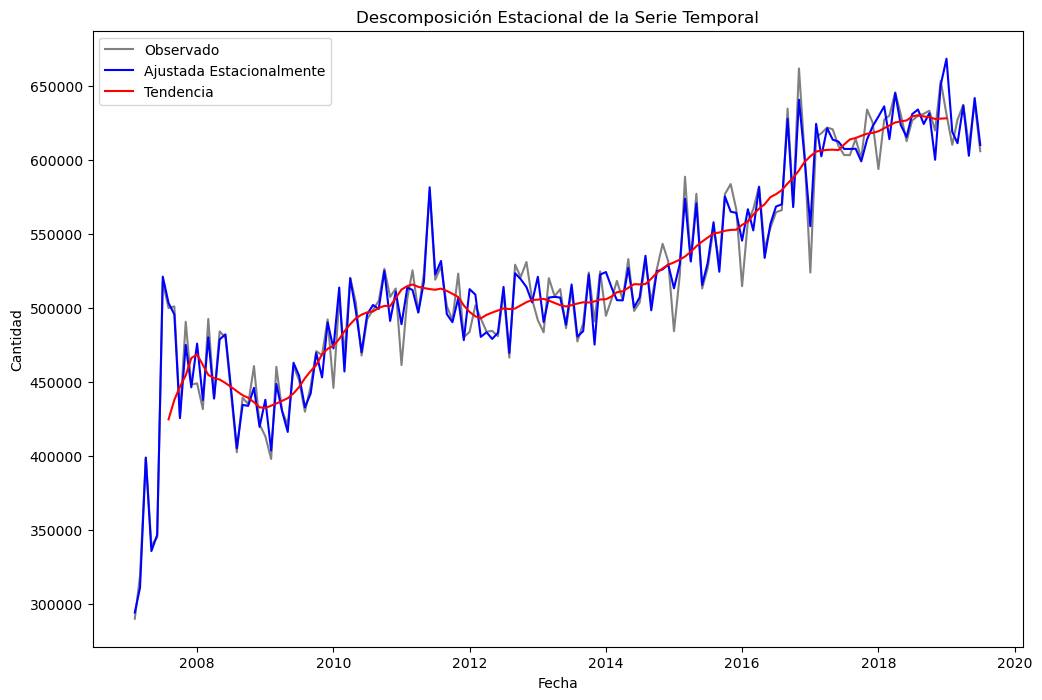

In [24]:
# 3) Crear un gráfico que muestre las componentes
plt.figure(figsize=(12, 8))
plt.plot(result.observed, label='Observado', color='grey')
plt.plot(result.observed/result.seasonal, label='Ajustada Estacionalmente', color='blue')
plt.plot(result.trend, label='Tendencia', color='red')
# Añadir leyendas y título
plt.legend()
plt.title('Descomposición Estacional de la Serie Temporal')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
# Mostrar el gráfico
plt.show()

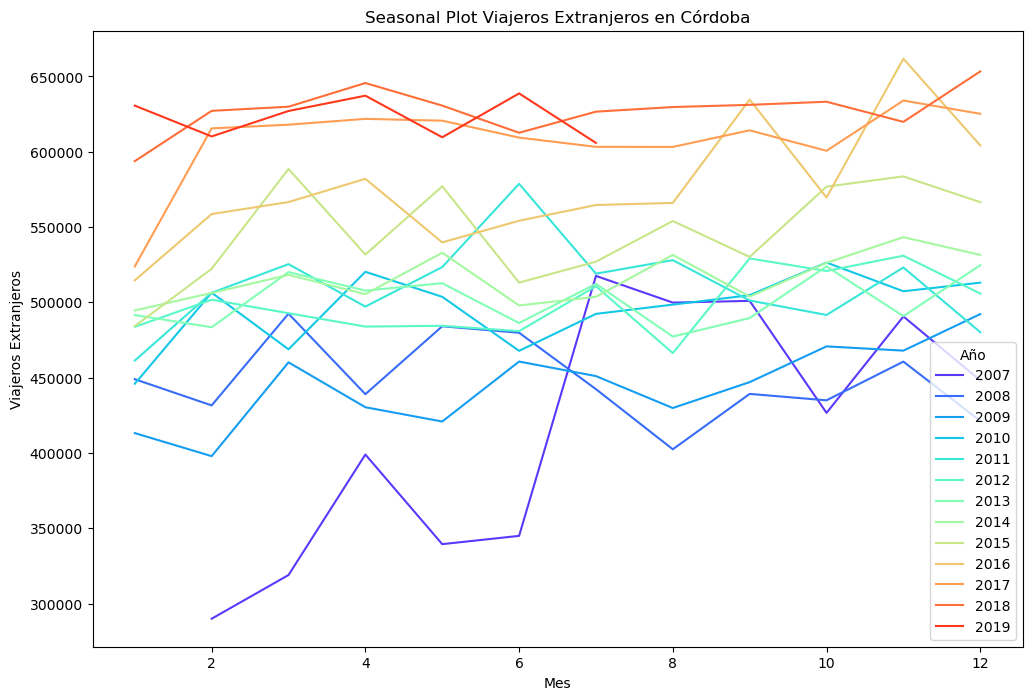

In [25]:
# Asegúrate de que el índice sea datetime
serie.index = pd.to_datetime(serie.index)

plt.figure(figsize=(12, 8))

years = serie.index.year
years_unique = sorted(years.unique())
colors = sns.color_palette("rainbow", len(years_unique))
year_to_color = {y: colors[i] for i, y in enumerate(years_unique)}

for año, datos_año in serie.groupby(serie.index.year):
    plt.plot(
        datos_año.index.month,
        datos_año.values,
        label=str(año),
        color=year_to_color[año]
    )

plt.legend(title='Año')
plt.title('Seasonal Plot Viajeros Extranjeros en Córdoba')
plt.xlabel('Mes')
plt.ylabel('Viajeros Extranjeros')
plt.show()


In [31]:


def transform_log_diff_shift(serie: pd.Series, eps: float = 1e-6):
    """
    1) Log transform para estabilizar varianza
    2) Diferenciación de orden 1 para reducir no-estacionariedad en media
    3) Shift para evitar valores negativos (opcional, pero lo aplicamos como pediste)
    
    Retorna:
      - serie_transf: serie lista para modelado/partición
      - params: diccionario con parámetros necesarios para revertir transformaciones
    """
    # Seguridad: evitar log(0) (si hubiese ceros). En precios normalmente no aplica, pero lo dejamos robusto.
    serie_pos = serie.copy()
    if (serie_pos <= 0).any():
        # Ajuste mínimo para positividad
        adj = abs(serie_pos.min()) + eps
        serie_pos = serie_pos + adj
    else:
        adj = 0.0

    # 1) Log
    serie_log = np.log(serie_pos)

    # 2) Diferencia orden 1
    serie_log_diff = serie_log.diff(1).dropna()

    # 3) Shift para no-negatividad
    min_diff = float(serie_log_diff.min())
    shift = (-min_diff) + eps if min_diff <= 0 else 0.0
    serie_ready = serie_log_diff + shift

    params = {
        "eps": eps,
        "add_to_make_positive_before_log": float(adj),
        "shift_after_diff": float(shift),
        "last_log_value_before_diff": float(serie_log.iloc[-1]),  # útil para invertir predicciones
        "last_timestamp": serie_log.index[-1],
    }

    return serie_ready, params

In [32]:
serie_modelo, tparams = transform_log_diff_shift(serie)

In [33]:
result = seasonal_decompose(serie_modelo, model='multiplicative', period=12)